# code2vec model
## Выглядит так: 
![code2vec](img/code2vec_network.jpg)


мы существуем в папке experimental, поэтому нужно вернуться в корень репозитория, чтобы иметь доступ к vocabulary.py и path_context_reader.py

In [1]:
%cd ../

/home/rkulagin/university/IU8-8-3/TiMP-course-project/code/code2vec


Базовая инициализация необходимых для работы переменных. 

In [2]:
import tensorflow as tf
import tensorboard
import os
import datetime
import config
import numpy as np
from vocabulary import Code2VecVocabs
from path_context_reader import PathContextReader, ReaderInputTensors
config.config.CREATE_VOCAB = True
config.config.TRAINING_FREQ_DICTS_PATH = "dataset/java-small/java-small.c2v.dict"
c2v_vocabs = Code2VecVocabs()
pcr = PathContextReader(is_train=True, vocabs=c2v_vocabs, csv_path="dataset/java-small/java-small.train_vec.csv")
dataset = pcr.get_dataset()
#init lookups
c2v_vocabs.target_vocab.get_word_to_index_lookup_table()
c2v_vocabs.token_vocab.get_word_to_index_lookup_table()
c2v_vocabs.path_vocab.get_word_to_index_lookup_table()


Creating vocab from dataset/java-small/java-small.c2v.dict
Loading frequency dicts from dataset/java-small/java-small.c2v.dict
Loading token freq dict
Loading path freq dict
Loading target freq dict
Creating token vocab
Creating vocab from frequency dictionary of 3367 elements
Created token vocab
Creating path vocab
Creating vocab from frequency dictionary of 35452 elements
Created path vocab
Creating target vocab
Creating vocab from frequency dictionary of 618 elements
Created target vocab
Created all vocabs


Константы, которые потом будут помещены в config.config

In [3]:
EMBED_DIMENSION = 200
DROPOUT_KEEP_RATE = 0.75
TOKEN_VOCAB_SIZE = c2v_vocabs.token_vocab.lookup_table_word_to_index.size().numpy()
TARGET_VOCAB_SIZE=c2v_vocabs.target_vocab.lookup_table_word_to_index.size().numpy()
PATH_VOCAB_SIZE = c2v_vocabs.path_vocab.lookup_table_word_to_index.size().numpy()

Переформатировать dataset для подачи tuple(x, y) в code2vec. x- tuple из путей-контекстов и имён функций

In [4]:
dataset = dataset.map(lambda x : {'x': (x.path_source_token_indices, x.path_indices, x.path_target_token_indices, x.target_index), 'y': x.target_index})

Создаём модели для эмбедов token-ов

In [5]:
input_source_token_embed = tf.keras.Input(shape = (config.config.MAX_CONTEXTS,), name="input_source_token")
input_target_token_embed = tf.keras.Input(shape = (config.config.MAX_CONTEXTS,), name="input_target_token")
token_embed = tf.keras.layers.Embedding(input_dim = TOKEN_VOCAB_SIZE, 
                                    output_dim=EMBED_DIMENSION,
                                    embeddings_initializer='uniform',
                                    name="token_embed") 
token_source_embed_model = tf.keras.Sequential([input_source_token_embed, token_embed])
token_target_embed_model = tf.keras.Sequential([input_target_token_embed, token_embed])
print(token_source_embed_model.summary())
print(token_target_embed_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
token_embed (Embedding)      (None, 300, 200)          673600    
Total params: 673,600
Trainable params: 673,600
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
token_embed (Embedding)      (None, 300, 200)          673600    
Total params: 673,600
Trainable params: 673,600
Non-trainable params: 0
_________________________________________________________________
None


Создаём модель для эмбедов путей

In [6]:
input_paths_embed = tf.keras.Input(shape=(config.config.MAX_CONTEXTS,), name="input_paths")
paths_embed = tf.keras.layers.Embedding(input_dim=PATH_VOCAB_SIZE, output_dim=EMBED_DIMENSION, embeddings_initializer='uniform', name="paths_embed")
path_embed_model = tf.keras.Sequential([input_paths_embed, paths_embed])
print(path_embed_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
paths_embed (Embedding)      (None, 300, 200)          7090600   
Total params: 7,090,600
Trainable params: 7,090,600
Non-trainable params: 0
_________________________________________________________________
None


Основная модель code2vec, то, что работает уже с эмбедами

In [7]:
concatenated_embeds = tf.keras.layers.Concatenate(name="concatenated_embeds")([token_source_embed_model.output, path_embed_model.output, token_target_embed_model.output])

droped_embeds = tf.keras.layers.Dropout(1-DROPOUT_KEEP_RATE)(concatenated_embeds)
flatten_embeds = tf.keras.layers.Reshape((-1, 3*EMBED_DIMENSION), name="flatten_embeds")(droped_embeds)
combined_context_vector = tf.keras.layers.Dense(3*EMBED_DIMENSION, activation='tanh', name="combined_context_vector")(flatten_embeds)
сontext_weights = tf.keras.layers.Dense(1, activation='softmax', name="context_weights")(combined_context_vector)
attention_weights = tf.keras.layers.Reshape((-1, config.config.MAX_CONTEXTS, 1), name="attention_weights")(сontext_weights)

batched_embed = tf.keras.layers.Reshape((-1, config.config.MAX_CONTEXTS, 3*EMBED_DIMENSION), name="batched_embed") (combined_context_vector)
code_vectors = tf.keras.layers.Multiply()([batched_embed, attention_weights])
code_vectors = tf.keras.backend.squeeze(code_vectors, axis=1)
code_vectors = tf.keras.backend.sum(code_vectors, axis=1) # У меня есть подозрение, что руинит что-то из подобных функций

Эмбед для target

In [8]:
input_target_embed = tf.keras.Input(shape=(1,), dtype=tf.int64, name="target")
target_embed = tf.keras.layers.Embedding(input_dim=TARGET_VOCAB_SIZE, 
                                        output_dim=3*EMBED_DIMENSION,
                                        embeddings_initializer='uniform',
                                        name="target_embed") (input_target_embed)
target_embed = tf.keras.backend.squeeze(target_embed, axis=1)
target_embed_model = tf.keras.Model(inputs=input_target_embed, outputs=target_embed)
print(target_embed_model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
target (InputLayer)          [(None, 1)]               0         
_________________________________________________________________
target_embed (Embedding)     (None, 1, 600)            371400    
_________________________________________________________________
tf_op_layer_Squeeze_1 (Tenso [(None, 600)]             0         
Total params: 371,400
Trainable params: 371,400
Non-trainable params: 0
_________________________________________________________________
None


Финальный этап - подсчёт logits

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_source_token (InputLayer) [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_paths (InputLayer)        [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_target_token (InputLayer) [(None, 300)]        0                                            
__________________________________________________________________________________________________
token_embed (Embedding)         (None, 300, 200)     673600      input_source_token[0][0]         
                                                                 input_target_token[0][

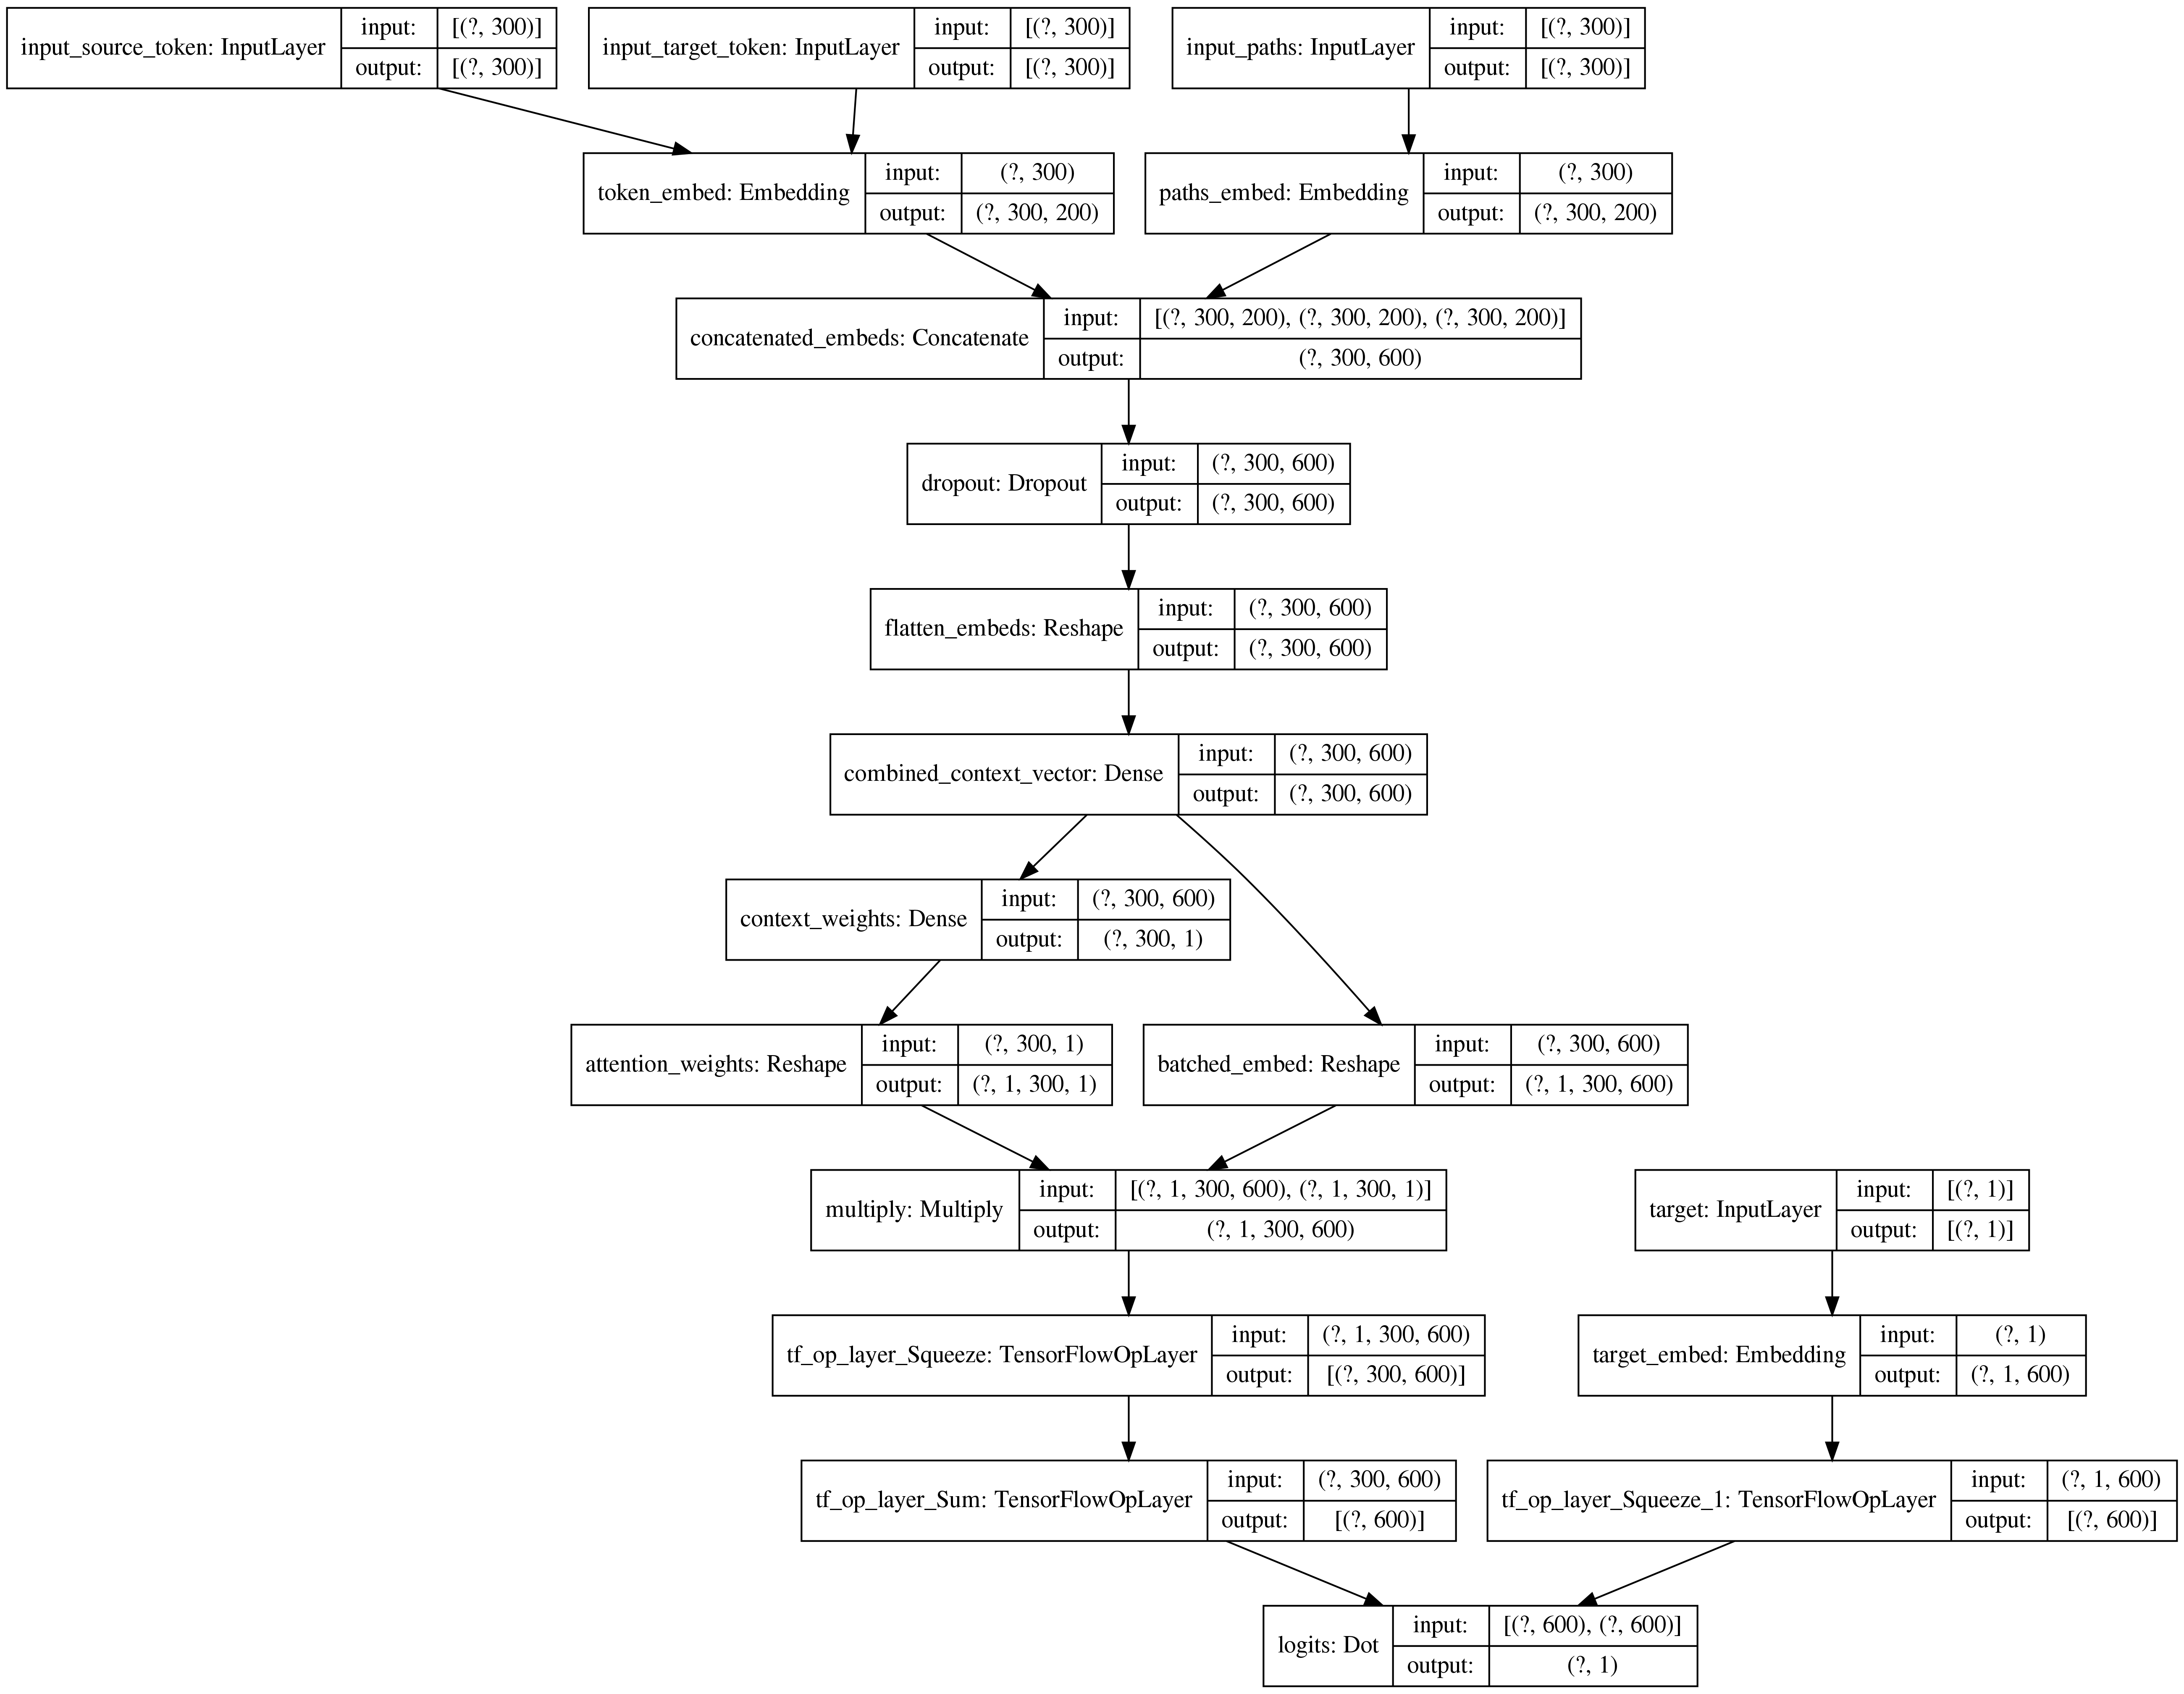

In [9]:
logits = tf.keras.layers.Dot([1, 1],name="logits")([code_vectors, target_embed_model.output])
batch_size = tf.cast(tf.shape(input_target_embed)[0], tf.float32)

code2vec = tf.keras.Model(inputs=[token_source_embed_model.input, path_embed_model.input, token_target_embed_model.input, target_embed_model.input], outputs=logits)
print(code2vec.summary())
tf.keras.utils.plot_model(code2vec, show_shapes=True, dpi=300)

In [10]:
def tf_loss(labels, logits):
    """custom loss function"""
    return tf.keras.backend.sum(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.reshape(labels, [-1]), logits=logits)) / config.config.BATCH_SIZE

In [11]:
code2vec.compile(optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'],  loss=tf_loss, run_eagerly=False)


In [12]:
code2vec.fit(dataset)

ValueError: in user code:

    /home/rkulagin/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/rkulagin/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/rkulagin/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/rkulagin/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/rkulagin/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/rkulagin/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/rkulagin/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:757 train_step
        self.trainable_variables)
    /home/rkulagin/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:2737 _minimize
        trainable_variables))
    /home/rkulagin/.local/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:562 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    /home/rkulagin/.local/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:1271 _filter_grads
        ([v.name for _, v in grads_and_vars],))

    ValueError: No gradients provided for any variable: ['token_embed/embeddings:0', 'paths_embed/embeddings:0', 'combined_context_vector/kernel:0', 'combined_context_vector/bias:0', 'context_weights/kernel:0', 'context_weights/bias:0', 'target_embed/embeddings:0'].


In [13]:
code2vec.trainable_variables

[<tf.Variable 'token_embed/embeddings:0' shape=(3368, 200) dtype=float32, numpy=
 array([[ 0.03733622,  0.04743669,  0.03447283, ...,  0.0236751 ,
          0.02890736,  0.02841593],
        [ 0.02271192,  0.02546762,  0.00053748, ...,  0.04304106,
          0.03989187, -0.02914897],
        [-0.03188882, -0.04720894, -0.01087631, ...,  0.02768144,
          0.02576102,  0.00677907],
        ...,
        [-0.01933509, -0.00974009, -0.0472495 , ..., -0.00537244,
          0.03657759,  0.03238142],
        [-0.00696673, -0.04380793, -0.03642838, ...,  0.00613131,
         -0.02971672, -0.03412727],
        [-0.02133074, -0.03381483, -0.02901913, ...,  0.02478346,
         -0.04279821,  0.01626564]], dtype=float32)>,
 <tf.Variable 'paths_embed/embeddings:0' shape=(35453, 200) dtype=float32, numpy=
 array([[ 0.03361947,  0.01966708,  0.00031359, ..., -0.04433399,
         -0.0439111 , -0.02608548],
        [ 0.00961353,  0.04086459,  0.00772611, ..., -0.02599329,
          0.03059663,  0.0